# First approach: Managing Unexpected and Immediate Runway Closure

## Testing Search Problem Algorithm
This notebook will test for different scenarios using the custom defined classes and solver algorithm.
The solvers will set up the search problem varying the fiollowing parameters:
* n_runway
* max_delay
* duration of disruption (by chaning the paramter `resume_hour` and/or `resume_min`)
* Number of flights to consider (by changing the df passed into the `search_pronble` class)

By default, the `resschedule_problem` class defines the problem with the following parameters:
* n_runway = 1
* disruption_dur = 60 (in minutes)
* duration of time slot = 5 (in minutes)
* Maximum delay permissible before a flight has to be diverted (canceled) = 120


In [3]:
import pandas as pd 
import numpy as np
import itertools
# _________________________________
# search problem
class reschedule_problem:

    def __init__(self,df, n_runway = 1, disruption_dur = 60,\
                timeslot_dur = 5, max_delay = 120,divert_penalty = 1):
        # customized attributes of the problem
        self.df = df
        self.move = df['code']
        self.n_runway = n_runway
        self.resumetime = self.df.iloc[0,0] + pd.Timedelta(minutes = disruption_dur)
        self.hour = self.resumetime.hour
        self.min = self.resumetime.minute
        self.time_slot_duration = timeslot_dur
        self.max_delay = max_delay
        self.divert_penalty = divert_penalty # referenced in self.compute_util
        # parsing the attribute for more useful format
        self.date = self.df.loc[0,'time_sch'].day
        self.month = self.df.loc[0,'time_sch'].month
        self.year = self.df.loc[0,'time_sch'].year
        self.initial = pd.DataFrame(columns = ["time_new","util"], index= []) # to store the solution
        self.solution = None

    def actions(self, state:pd.DataFrame):
        """return a list of n_runway flight(s) that has/have is expected to land
        and is not assigned a time slot under the state; and one list of flight
        that has to be diverted"""
        # get the list of unassigned flight where the time_sch is (over)due under current time slot 
        assigned_flight = list([flight for flight in state.index])
        unassigned_flight = self.df.query("code not in @assigned_flight").copy()
        # subset the flights that are not in time yet / not diverted
        year, month, date, hour, min = self.parse_state_time(state)
        current_time = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
        min_time = pd.to_datetime(f"{year} {month} {date} {hour}:{min}") - pd.Timedelta(minutes = self.max_delay)
        # create boolean columns for subsetting diverted flights and those to schedule
        unassigned_flight['divert'] = unassigned_flight.apply(lambda flight: flight['time_sch'] < min_time,axis = 1)
        unassigned_flight['to_sch'] = unassigned_flight.apply(lambda flight: flight['time_sch'] <=current_time  ,axis = 1)

        # return the pd.Series of unassigned flight that has passed its schedule time
        flight_to_assign = unassigned_flight[unassigned_flight['to_sch'] & ~(unassigned_flight['divert'])]['code']
        # return the combination of flights (namely when n_runway > 1)
        flight_to_assign = [comb for n in range(1, self.n_runway+1) for comb in itertools.combinations(flight_to_assign, n)]
        # flight to divert
        flight_diverted = unassigned_flight[unassigned_flight['divert']]['code']

        return flight_to_assign, flight_diverted # pd.Series
        
    def parse_state_time(self,state:pd.DataFrame):
        """Use to get the value in the schedule and 
        parse the time of the next time slot"""
        if len(state) <=0: 
            year = self.year
            month = self.month
            date = self.date
            hour = self.hour
            min = self.min

        else:
            timestr = state['time_new'].iloc[-1] # get the time_sch
            year, month, date, time = timestr.split(" ")
            hour , min = time.split(":")
            # get the current time
            min = int(min)
            min += self.time_slot_duration
            if min // 60 <= 1:
                hour = int(hour) + min // 60
                min = min % 60
                if hour // 24 <= 1:
                    date = int(date) + hour // 24
                    hour = hour % 24
                
        return year, month, date, hour,min
    
    def result(self, state:pd.DataFrame, flight_diverted:list, flights:list):
        """return the state in a form of dictionary that is the result of a given move"""
        # parse the time data
        year, month, date, hour, min = self.parse_state_time(state)

        if len(flights) != 0:
            for fl in flights:
                time_sch = f"{year} {month} {date} {hour:02d}:{min:02d}"
                # get the utility
                util = self.compute_util(fl, year, month, date, hour, min)
                # print(f"Scheudling {flights} for {time_sch}")
                state.loc[fl] = [time_sch, util]
        elif not self.goal_test(state):
            # no flight can be assigned to the time slot
            time_sch = f"{year} {month} {date} {hour:02d}:{min:02d}"
            fl ='no flight to assign'
            state.loc[fl] = [time_sch, 0]
    
        # add the diverted flight into the state
        for fl in flight_diverted:
            util = self.compute_util(fl,1970, 0,0,0,0)
            state.loc[fl] = ["1970 01 01 00:00", util]
            # print(f"Diverting {flights}")

        # sort the state df by the new scheduled time
        state = state.sort_values("time_new")

        return state # pd.DataFrame
    
    def compute_util(self, flcode:str, year, month, date, hour, min):
        """Compute the utility of a given rescheduled flight. This is defined
        as the time difference between the original scheduled time and the 
        new scheduled time"""
        if flcode is None:
            return 0 
        elif year != 1970:
            time_sch_org = self.df.query("code == @flcode")['time_sch'] # type pd Series
            time_sch_new = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
            # compute the time delayed
            delay = time_sch_org - time_sch_new
            delay = delay.reset_index(drop = True)[0].total_seconds() / 60
            return delay
        elif year == 1970:
            # compute utility of diverted flight
            delay = - self.max_delay * self.divert_penalty
            return delay
    
    def utility(self, state:pd.DataFrame):
        """Compute aggregate utility of a given state"""
        agg_util = state['util'].sum()
        return agg_util
        
    def goal_test(self, state:pd.DataFrame):
        """return True if the state is terminal"""
        flight_assigned = [flight for flight in state.index] 
        if len(flight_assigned) == len(self.df):
        # !!! this is not a robust way since time slot can be none
            return True
        
    def solve(self, solver_algo):
        self.solution = solver_algo(self)   
        if self.solution is None:
            print("No solution is returned")
        
    def display(self):
        """ Display the self.solution that is of type pandas dataframe
        to compare the solution with the set up that we try to solve 
        """
        if self.solution is None:
            print("The problem has not been solved. Pass a solving algorithm to the .solve method")
            raise NotImplementedError
        elif type(self.solution) != pd.core.frame.DataFrame:
            print("""THe solution returned by the algorithm cannot be parsed because it is 
                  not of type pd.core.frame.DataFrame""")
        
        display_df = self.df.copy()
        display_df = pd.merge(self.df[['code','time_sch','pass_load']], self.solution, left_on= "code", right_index = True)
        display_df['time_new'] = pd.to_datetime(display_df['time_new'])
        display_df['time_dff'] = display_df.apply(lambda x: (x['time_sch'] - x['time_new']).total_seconds()/ 60,axis = 1 )
        display_df['time_dff'] = display_df['time_dff'].apply(lambda x: -x if x <= 0 else "diverted" )
        n_diverted = len(display_df.query("time_dff == 'diverted'"))
        print(f"{n_diverted} flights being diverted")
        return display_df
    
    def get_basemodel(self):
        given_data = self.df.copy()
        base_df = self.initial.copy()

        def parse_time_string(timestamp):
            year = timestamp.year
            month = timestamp.month
            day = timestamp.day
            hour = timestamp.hour
            minute = timestamp.minute
            return year, month, day, hour, minute

        year, month, date, hour, min = parse_time_string(self.resumetime)
        flights_in_slot = 0
        for _, flight in given_data.iterrows():
            time_sch_org = flight['time_sch'] # type pd Series
            time_sch_new = pd.to_datetime(f"{year}-{month}-{date} {hour}:{min}")
            if (time_sch_org - time_sch_new).total_seconds() < 0:
                time_sch = f"{year} {month} {date} {hour:02d}:{min:02d}"
                util = self.compute_util(flight['code'], year, month, date, hour, min)
            else: 
                time_sch = time_sch_org.strftime("%Y %m %d %H:%M")
                util = 0
            base_df.loc[flight['code']] = [time_sch, util]

            # Increment flight count and time slot only if the slot is full
            ori_min = min
            flights_in_slot += 1
            if flights_in_slot >= self.n_runway:
                min = ori_min + self.time_slot_duration
                flights_in_slot = 0
                if min >= 60:
                    hour += 1
                    min -= 60
                    if hour >= 24:
                        date += 1
                        hour -= 24
                ori_min = min

        display_df = self.df.copy()
        display_df = pd.merge(self.df[['code','time_sch','pass_load']], base_df, left_on= "code", right_index = True)
        display_df['time_new'] = pd.to_datetime(display_df['time_new'])
        display_df['time_dff'] = display_df.apply(lambda x: (x['time_sch'] - x['time_new']).total_seconds()/ 60,axis = 1 )
        display_df['time_dff'] = display_df['time_dff'].apply(lambda x: -x if x <= 0 else "diverted" )
        n_diverted = len(display_df.query("time_dff == 'diverted'"))
        print(f"{n_diverted} flights being diverted")
        return display_df

# __________________________
# search problem with alternative u function
class reschedule_custom_u(reschedule_problem):
    """inherit the properties of class reschedule_problem, but takes an additional
    argument`util_f`, a function that has two argment: delay and pass_load used to
    calculate the utility of the flights"""

    def __init__(self, df,util_f, n_runway = 1, disruption_dur = 60,
                timeslot_dur = 5, max_delay = 120, divert_penalty = 1):
        super().__init__(df, n_runway , disruption_dur,
                timeslot_dur, max_delay, divert_penalty)
        self.util_f = util_f


    def compute_util(self, flcode, year, month, date, hour, min):
        """Compute the utility of a given rescheduled flight. This is defined
        as the time difference between the original scheduled time and the 
        new scheduled time"""
        if flcode is None:
            return 0 
        elif year != 1970:
            time_sch_org = self.df.query("code == @flcode")['time_sch'] # type pd Series
            time_sch_new = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
            # compute the time delayed
            delay = time_sch_org - time_sch_new
            delay = delay.reset_index(drop = True)[0].total_seconds() / 60

        elif year == 1970:
            # compute utility of diverted flight
            delay = - self.max_delay * self.divert_penalty

        pass_load = self.df.query("code == @flcode")['pass_load'].values[0]
        util = self.util_f(delay, pass_load)

        return util

#____________________________
# search problem with alternative u function and discount on future U
class reschedule_custom_u_dis(reschedule_custom_u):
    """inherit the properties of `reschedule_custom_u`, taking an
    additional argument `dis_rate` which defines how much 
    we value the uncertainty of flights originally scheduled for later"""

    def __init__(self, df,util_f, n_runway = 1, disruption_dur = 60,
                timeslot_dur = 5, max_delay = 120, divert_penalty = 1, dis_rate = 1.05):
        super().__init__(df, util_f,n_runway , disruption_dur,
                timeslot_dur, max_delay, divert_penalty)
        self.dis_rate = dis_rate

    def compute_util(self, flcode, year, month, date, hour, min):
        """Compute the utility of a given rescheduled flight. This is defined
        as the time difference between the original scheduled time and the 
        new scheduled time"""
        
        if flcode is None:
            return 0 
        elif year != 1970:
            time_sch_org = self.df.query("code == @flcode")['time_sch'] # type pd Series
            time_sch_new = pd.to_datetime(f"{year} {month} {date} {hour}:{min}")
            # compute the time delayed
            delay = time_sch_org - time_sch_new
            delay = delay.reset_index(drop = True)[0].total_seconds() / 60

        elif year == 1970:
            # compute utility of diverted flight
            delay = - self.max_delay * self.divert_penalty

        pass_load = self.df.query("code == @flcode")['pass_load'].values[0]
        util = self.util_f(delay, pass_load)
        # compute discounted util
        time_sch_org = self.df.query("code == @flcode")['time_sch'] # type pd Series
        time_elapse = time_sch_org.values[0]  - self.resumetime
        time_elapse = time_elapse.total_seconds()
        time_period = time_elapse / 60 / self.time_slot_duration
        dis_util = util / (self.dis_rate ** time_period)

        return dis_util

# ____________________________
# node
class Node:
    """This takes a lot of refeneces to the AMINA class node"""
    def __init__(self, state,parent = None, action = None, path_cost = 0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0 
        if parent:
            self.depth = parent.depth + 1
    def __repr__(self):
        """define printing output of the class type"""
        return "<Node of depth {}>".format(self.depth)
    
    def __lt__(self, node):
        """Compare the depth of the nodes -- for use in 
        sorting the *frontier*"""
        return self.depth < node.depth
    
    def expand(self, problem):
        """reach the nodes reachable"""
        flight_to_assign, flight_diverted = problem.actions(self.state)
        if len(flight_to_assign) == 0:
            # when no flight can be assigned at the time slot
            flight_to_assign.append(list())
        return [self.child_node(problem, action, flight_diverted) 
                  for action in flight_to_assign]

    def child_node(self, problem,action, flight_diverted):
        """ Return a Node object representing the child node        
        """
        parent_state = self.state.copy()
        next_state = problem.result(parent_state, flight_diverted, action)
        # print(next_state)
        next_node = Node(next_state, parent=self, action = action, path_cost = problem.utility(next_state))
        return next_node # node object

    
# ____________________________________________
# bfs graph
def best_first_graph_search(problem):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""

    # adding first node
    node = Node(problem.initial)
    print(f"The airport resumed service at {problem.hour}:{problem.min:02d}")
    iterations = 1
    # applying the goal test when generating the node
    if problem.goal_test(node.state):
        return(iterations, node)

    # expand the frontier based on the priority queue
    # the current best candidate for extension
    frontier = list()
    frontier.append(tuple([node.path_cost,node ]))

    while frontier:
        if iterations % 1000 == 0:
            break_command = input("""1000 iterations operated. Continue or break? 
                                  Type in 'break' to break the loop, otherwise anything else""")
            if break_command is not None:
                if break_command.lower().strip == 'break':
                    break
        # get the next node in the frontier
        node = frontier.pop()[1]
        iterations +=1
        # applying the goal test when expanding the node
        if problem.goal_test(node.state):
            return node.state
        # for every child in the frontier
        for child in node.expand(problem): # child is a node
            frontier.append(tuple([int(child.path_cost),child]))
            frontier.sort(reverse = True) # order from lower cost to higher cost (absolute terms)

    print("No solution is returned by the solver algorithm")
    return None # otherwise return node.state
    
# ____________________________________________
# bfs graph
def breadth_first_search(problem):
    """Search the nodes with the lowest depth scores first.
    """
    # adding first node
    node = Node(problem.initial)
    print(f"The airport resumed service at {problem.hour}:{problem.min:02d}")
    iterations = 1
    # applying the goal test when generating the node
    if problem.goal_test(node.state):
        return(iterations, node)

    solutions = []
    # expand the frontier based on the priority queue
    # the current best candidate for extension
    frontier = list()
    frontier.append(tuple([node.depth,node ]))

    while frontier:
        # get the next node in the frontier
        node = frontier.pop()[1]
        # applying the goal test when expanding the node
        if problem.goal_test(node.state):
            # add the node to the list of dictionary
            solutions.append(tuple([node.path_cost,node]))
            print(f"A terminal state has been reached: total {len(solutions)} solutions")
        else:
            # for every child in the frontier
            for child in node.expand(problem): # child is a node
                print(f"Iteration: {iterations} at depth {child.depth}")
                print((f"Check if the depth is consistent withe the node state."))
                print(f"There should be {len(child.state)/problem.n_runway} timeslot iterated.")
                frontier.append(tuple([int(child.depth),child]))
                frontier.sort(reverse = True) # order from lower cost to higher cost (absolute terms)
                iterations+= 1
            
                if iterations % 1000 == 0:
                    msg = "1000 iterations processed. Continue or break? Type 'break' to break out of the loop"
                    command_input = input("Continue or break?")
                    try:
                        command_input = command_input.lower.strip() 
                    except:
                        command_input = None
                    if command_input != "break":
                        break

    # <return the solution from the list that has the maximum utility>
    # compute the utilityof all the solution yielded
    solutions.sort(reverse = True)
    # return the   
    return solutions

In [4]:
df = pd.read_csv("./data/21DEC2023_AMS_processed.csv", parse_dates = ['time_sch','time_act'])
df = df.sort_values("time_sch").reset_index(drop = True)
df.head()

,time_sch,time_act,code,dest,stat,orig,pass_load,time_diff
0,2023-12-21 00:10:00,2023-12-21 01:19:00,HV 6888 Transavia,Amsterdam,BAGGAGE HANDLED,Reykjavik (KEF),383,4140.0
1,2023-12-21 00:25:00,2023-12-21 00:25:00,HV 5336 Transavia,Amsterdam,BAGGAGE HANDLED,Sharm El Sheikh (SSH),364,0.0
2,2023-12-21 01:00:00,2023-12-21 01:00:00,HV 6676 Transavia,Amsterdam,BAGGAGE HANDLED,Tenerife (TFS),319,0.0
3,2023-12-21 05:45:00,2023-12-21 05:45:00,KL 590 KLM,Amsterdam,BAGGAGE HANDLED,Accra (ACC),238,0.0
4,2023-12-21 05:50:00,2023-12-21 06:44:00,KL 810 KLM,Amsterdam,BAGGAGE HANDLED,Jakarta (CGK),327,3240.0


## Test 1: Uniform Cost Search
In this first case, we will consider:
* a dataframe of size 20
* n_runway = 2
* duration of disruption = 60

We set up the problem using the `reschedule_problem` class which defines the path cost as the time delayed of the flight scheduled at the child node.

In [5]:
# subset the tail of the dataframe
df_subset = df.tail(20).reset_index(drop = True)
df_subset.head()

,time_sch,time_act,code,dest,stat,orig,pass_load,time_diff
0,2023-12-21 22:30:00,2023-12-21 22:30:00,OR 3802 TUI fly,Amsterdam,BAGGAGE HANDLED,Tenerife (TFS),236,0.0
1,2023-12-21 22:35:00,2023-12-21 22:35:00,LH 2310 Lufthansa,Amsterdam,CANCELLED,Munich (MUC),339,0.0
2,2023-12-21 22:35:00,2023-12-21 23:37:00,KL 1032 KLM,Amsterdam,BAGGAGE HANDLED,London Heathrow (LHR),344,3720.0
3,2023-12-21 22:40:00,2023-12-22 01:10:00,AZ 118 ITA Airways,Amsterdam,BAGGAGE ON BELT,Milan Linate (LIN),346,-77400.0
4,2023-12-21 23:00:00,2023-12-21 23:00:00,KL 1706 KLM,Amsterdam,CANCELLED,Madrid (MAD),316,0.0


In [6]:
# instantiate the problem
AMS21_n20_1 = reschedule_problem(df_subset, n_runway = 2)
# solve the problem
AMS21_n20_1.get_basemodel()


0 flights being diverted


,code,time_sch,pass_load,time_new,util,time_dff
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:30:00,-60.0,60.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:30:00,-55.0,55.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:35:00,-60.0,60.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:35:00,-55.0,55.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:40:00,-40.0,40.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:40:00,-40.0,40.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:45:00,-45.0,45.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:45:00,-45.0,45.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:50:00,-45.0,45.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:50:00,-35.0,35.0


In [7]:
AMS21_n20_1.solve(best_first_graph_search)
AMS21_n20_1.display()

The airport resumed service at 23:30


0 flights being diverted


,code,time_sch,pass_load,time_new,util,time_dff
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:30:00,-60.0,60.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:35:00,-60.0,60.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:30:00,-55.0,55.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:35:00,-55.0,55.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:45:00,-45.0,45.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:45:00,-45.0,45.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:40:00,-40.0,40.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:40:00,-40.0,40.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:50:00,-45.0,45.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:55:00,-40.0,40.0


## Test 2 Breadth-First Search
Here we use the breadth first tree search, assuming that the path cost is the depth of the node.
We can see from this particularly case, there is a significant increase of the runtime. 

In this section, we set up the problem for rescheduling 6 flights only because breadth-first search, in general, has a high time complexity as the algorithm seeks to conduct a complete search of all possible terminal state. As such, we also reduce the time of airport disruption to 20 min.

In [8]:
# subset
df_subset_2 = df.tail(6).reset_index(drop = True)
# instantiate the problem
AMS21_n6_2 = reschedule_problem(df_subset_2, n_runway = 2,max_delay=120, disruption_dur= 20)
# solve the problem
AMS21_n6_2.solve(breadth_first_search)
# return the solution
breadth_fs_sol_2 = AMS21_n6_2.solution

The airport resumed service at 23:45
Iteration: 1 at depth 1
Check if the depth is consistent withe the node state.
There should be 0.5 timeslot iterated.
Iteration: 2 at depth 1
Check if the depth is consistent withe the node state.
There should be 0.5 timeslot iterated.
Iteration: 3 at depth 1
Check if the depth is consistent withe the node state.
There should be 0.5 timeslot iterated.
Iteration: 4 at depth 1
Check if the depth is consistent withe the node state.
There should be 0.5 timeslot iterated.
Iteration: 5 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 6 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 7 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 8 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 9 at dep

In [9]:
# inspect the result
n_sol =len(breadth_fs_sol_2)
print(f"There are in total {n_sol} number of solution.")
# unzip the solution list
max_util = breadth_fs_sol_2[0][0]
sol_max_score = [node for util, node in breadth_fs_sol_2 if util == max_util]
print(f"The maximum utility of all solution is {max_util}, with {len(sol_max_score)} yielding this utility")

There are in total 1612 number of solution.
The maximum utility of all solution is -75.0, with 18 yielding this utility


As expected, the algorithm takes a long time before it returns a solution. With this reduced case of rescheduling only 6 flights, it takes more than 15 seconds for the algorithm to complete.
It returns all 1614 solutions, out of which 12 share the same utility of -80, that is the maximum utility across all the solutions.

In fact, the time complexity for the breath first search algorithm put a lot of stress on the computation power and it is simply not feasible to rely on the algorithm this resolve the scheduling issue when a lot of flights have to be rescheduled: Empirically, rescheduling 10 flights takes more than **20 min**. Due to the limitation of the computational power, we will not be discussing such case in this project.

Nonetheless, this highlight a major drawback of the application of best-first search in a real-world scenario:
* If there is not more flights to reschedule, rescheudling the flights with a simple rule of assigning the earliest slot to the earlist plan would not yield a lot of lost in utility. 
* If there is more flights to reschedule, then the algorith simply cannot return a solution within a feasible time constraint before an airport has to return to operation.

## Test 3 Model Comparison
In this section, let's compare the breath-first search algorith with the uniform-cost search. As discussed in the section above, breadth-first search requires a lot of computation. Hence, we will limit the size of our problem to rescheduling only 5 flights in thhis section for a fair comparison of the solution they return.

### Breadth-First Search

In [10]:
# subset
df_subset_3 = df.tail(6).reset_index(drop = True)
# instantiate the problem
AMS21_n5_3 = reschedule_problem(df_subset_3, n_runway = 1,max_delay=120, disruption_dur= 15)
# solve the problem
AMS21_n5_3.solve(breadth_first_search)
# the breadth first search returns a list of solution(s)
breadth_fs_sol_3 = AMS21_n5_3.solution

The airport resumed service at 23:40
Iteration: 1 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 2 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 3 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 4 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 5 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 6 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 7 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 8 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 9 at dep

In [11]:
# inspect the result
n_sol =len(breadth_fs_sol_3)
print(f"There are in total {n_sol} number of solution.")
# unzip the solution list
max_util = breadth_fs_sol_3[0][0]
sol_max_score = [node for util, node in breadth_fs_sol_3 if util == max_util]
print(f"The maximum utility of all solution is {max_util}, with {len(sol_max_score)} yielding this utility")

There are in total 216 number of solution.
The maximum utility of all solution is -90.0, with 216 yielding this utility


In [12]:
# print the optimal solution
breadth_fs_sol_3[0][1].state

,time_new,util
HV 6114 Transavia,2023 12 21 23:40,-15.0
HV 6902 Transavia,2023 12 21 23:45,-5.0
KL 1608 KLM,2023 12 21 23:50,-25.0
HV 5218 Transavia,2023 12 21 23:55,0.0
HV 5806 Transavia,2023 12 22 00:00,-30.0
HV 5666 Transavia,2023 12 22 00:05,-15.0


### Uniform Cost Search

In [13]:
AMS21_n5_3_2 = reschedule_problem(df_subset_3, n_runway = 1,max_delay=120, disruption_dur= 15)
AMS21_n5_3_2.solve(best_first_graph_search)
AMS21_n5_3_2_result = AMS21_n5_3_2.display()

The airport resumed service at 23:40
0 flights being diverted


In [14]:
AMS21_n5_3_2_result

,code,time_sch,pass_load,time_new,util,time_dff
0,HV 6114 Transavia,2023-12-21 23:25:00,300,2023-12-21 23:45:00,-20.0,20.0
1,KL 1608 KLM,2023-12-21 23:25:00,309,2023-12-21 23:40:00,-15.0,15.0
2,HV 5806 Transavia,2023-12-21 23:30:00,310,2023-12-21 23:50:00,-20.0,20.0
3,HV 6902 Transavia,2023-12-21 23:40:00,316,2023-12-21 23:55:00,-15.0,15.0
4,HV 5666 Transavia,2023-12-21 23:50:00,347,2023-12-22 00:00:00,-10.0,10.0
5,HV 5218 Transavia,2023-12-21 23:55:00,304,2023-12-22 00:05:00,-10.0,10.0


### Base model (First Come First Served)

In [15]:
# Instatiate and return the result
AMS21_n5_3 = reschedule_problem(df_subset_3, n_runway = 1,max_delay=120, disruption_dur= 15)
AMS21_n5_3_basemodel = AMS21_n5_3.get_basemodel()

0 flights being diverted


In [16]:
AMS21_n5_3_basemodel

,code,time_sch,pass_load,time_new,util,time_dff
0,HV 6114 Transavia,2023-12-21 23:25:00,300,2023-12-21 23:40:00,-15.0,15.0
1,KL 1608 KLM,2023-12-21 23:25:00,309,2023-12-21 23:45:00,-20.0,20.0
2,HV 5806 Transavia,2023-12-21 23:30:00,310,2023-12-21 23:50:00,-20.0,20.0
3,HV 6902 Transavia,2023-12-21 23:40:00,316,2023-12-21 23:55:00,-15.0,15.0
4,HV 5666 Transavia,2023-12-21 23:50:00,347,2023-12-22 00:00:00,-10.0,10.0
5,HV 5218 Transavia,2023-12-21 23:55:00,304,2023-12-22 00:05:00,-10.0,10.0


### Model Evaluation

In [17]:
# parse the result
compare_df = pd.merge(breadth_fs_sol_3[0][1].state, AMS21_n5_3_2_result[['code',"time_sch",'time_new','util']],
                left_index = True, right_on = 'code', suffixes = ("_breadth","_uniform"))
compare_df = pd.merge(compare_df, AMS21_n5_3_basemodel[['code','time_new','util']],on = 'code')
compare_df.rename(columns={'time_new': 'time_new_base', 'util': 'util_base'}, inplace=True)


In [18]:
# reorder and print result
compare_df[["code","time_sch",'time_new_breadth', 'util_breadth', 'time_new_uniform',
       'util_uniform','time_new_base','util_base']].sort_values("time_sch")

,code,time_sch,time_new_breadth,util_breadth,time_new_uniform,util_uniform,time_new_base,util_base
0,HV 6114 Transavia,2023-12-21 23:25:00,2023 12 21 23:40,-15.0,2023-12-21 23:45:00,-20.0,2023-12-21 23:40:00,-15.0
2,KL 1608 KLM,2023-12-21 23:25:00,2023 12 21 23:50,-25.0,2023-12-21 23:40:00,-15.0,2023-12-21 23:45:00,-20.0
4,HV 5806 Transavia,2023-12-21 23:30:00,2023 12 22 00:00,-30.0,2023-12-21 23:50:00,-20.0,2023-12-21 23:50:00,-20.0
1,HV 6902 Transavia,2023-12-21 23:40:00,2023 12 21 23:45,-5.0,2023-12-21 23:55:00,-15.0,2023-12-21 23:55:00,-15.0
5,HV 5666 Transavia,2023-12-21 23:50:00,2023 12 22 00:05,-15.0,2023-12-22 00:00:00,-10.0,2023-12-22 00:00:00,-10.0
3,HV 5218 Transavia,2023-12-21 23:55:00,2023 12 21 23:55,0.0,2023-12-22 00:05:00,-10.0,2023-12-22 00:05:00,-10.0


In [19]:
# compare the utility
compare_df[['util_breadth','util_uniform','util_base']].sum()

util_breadth   -90.0
util_uniform   -90.0
util_base      -90.0
dtype: float64

From this simple case, we can see that breadth search is not superior than the uniform cost search for this problem. In fact, this is due to the way we defined the utility function, which is the aggregate time-delayed per flight.

We we were to look at all solutions with the highest utilty returned by breadth-first search, we will see that in this problem set up the order of the flight being assigned actually has no effect on the utility in most cases.

For example, looking a the result directly from above, we see that the solution given by breadth-first search and uniform-cost search seems to be different. However, looking at the result from breadth-first search, we can see that if we were to swap the new time allocated to HV6114 and KL1608, it will still give us a result of the same utility. Therefore, in the following test, we will build up the complexity of the model by considering alternative utility function.

## Test 4
Instead of using the solely the time delayed, let's see if we define utility differently will yield variation in the performance between breadth-first search and uniform-cost search. We will use the `reschedule_custom_u` class to set up the problem. The class object have similar behaviours with the `rescheuld_problem` used above. The only difference is that it takes an additional argument `util_f` which defines the methodology of computing the utility of each rescheduled flight, which is defined as a function of:
* time-delayed
* Passenger load



Recall that the passenger load is a simulated data set that follows a normal distribution:
$$pass\_load ~ N(\mu= 300,\sigma^2=50^2)$$

The utility of each node is an additive function of all the individual time delayed (in minute) for each rescheduled flight calculated as:
$$\max(time\_sch - time\_new, max\_delay)$$

Note that utility takes a range of $(max\_delay,0]$, we can rescale with a function of passenger that increases at a decreasing scale. This weigh based on $pass\_load$ should have a range of $[0,1]$ and increases at a decreasing rate. A **proposed scale**:
$$\arctan(\frac{pass\_load}{200})\frac{2}{\pi}$$

With this function, it is more costly to delay a flight with more passenger than one with less if their originaly scheduled time is the same.

In [20]:
def util_f(delay, pass_load):
    scaled_pass_load = pass_load / 200
    util = delay * np.arctan(scaled_pass_load) /np.pi * 2
    return util


### Bread-First Search

In [21]:
# subset
df_subset_4 = df.tail(6).reset_index(drop = True)
# instantiate the problem
AMS21_n6_4 = reschedule_custom_u(df_subset_4,util_f, n_runway = 1,max_delay=120, disruption_dur= 15)
# solve the problem
AMS21_n6_4.solve(breadth_first_search)
# the breadth first search returns a list of solution(s)
breadth_fs_sol_4 = AMS21_n6_4.solution

# inspect the result
n_sol =len(breadth_fs_sol_4)
print(f"There are in total {n_sol} number of solution.")
# unzip the solution list
max_util = breadth_fs_sol_4[0][0]
sol_max_score = [node for util, node in breadth_fs_sol_4 if util == max_util]
print(f"The maximum utility of all solution is {max_util}, with {len(sol_max_score)} yielding this utility")

The airport resumed service at 23:40
Iteration: 1 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 2 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 3 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 4 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 5 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 6 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 7 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 8 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 9 at dep

Iteration: 47 at depth 3
Check if the depth is consistent withe the node state.
There should be 3.0 timeslot iterated.
Iteration: 48 at depth 3
Check if the depth is consistent withe the node state.
There should be 3.0 timeslot iterated.
Iteration: 49 at depth 3
Check if the depth is consistent withe the node state.
There should be 3.0 timeslot iterated.
Iteration: 50 at depth 3
Check if the depth is consistent withe the node state.
There should be 3.0 timeslot iterated.
Iteration: 51 at depth 3
Check if the depth is consistent withe the node state.
There should be 3.0 timeslot iterated.
Iteration: 52 at depth 3
Check if the depth is consistent withe the node state.
There should be 3.0 timeslot iterated.
Iteration: 53 at depth 4
Check if the depth is consistent withe the node state.
There should be 4.0 timeslot iterated.
Iteration: 54 at depth 4
Check if the depth is consistent withe the node state.
There should be 4.0 timeslot iterated.
Iteration: 55 at depth 4
Check if the depth is c

In [22]:
# print the optimal solution
breadth_fs_sol_4[0][1].state

,time_new,util
HV 6902 Transavia,2023 12 21 23:40,0.000000
HV 5806 Transavia,2023 12 21 23:45,-9.528576
HV 5666 Transavia,2023 12 21 23:50,0.000000
KL 1608 KLM,2023 12 21 23:55,-19.029023
HV 5218 Transavia,2023 12 22 00:00,-3.147738
HV 6114 Transavia,2023 12 22 00:05,-25.026637


### Uniform Cost Search

In [23]:
# Instatiate and return the result
AMS21_n6_4_2 = reschedule_custom_u(df_subset_4,util_f, n_runway = 1,max_delay=120, disruption_dur= 15)
AMS21_n6_4_2.solve(best_first_graph_search)
AMS21_n6_4_2_result = AMS21_n6_4_2.display()

The airport resumed service at 23:40
0 flights being diverted


### Base model (First Come First Served)

In [24]:
AMS21_n6_4_basemodel = AMS21_n6_4.get_basemodel()

0 flights being diverted


### Model Evaluation

In [25]:
# parse the result
compare_df = pd.merge(breadth_fs_sol_4[0][1].state, AMS21_n6_4_2_result[['code',"time_sch",'time_new','util']],
                left_index = True, right_on = 'code', suffixes = ("_breadth","_uniform"))
compare_df = pd.merge(compare_df, AMS21_n6_4_basemodel[['code','time_new','util']],on = 'code')
compare_df.rename(columns={'time_new': 'time_new_base', 'util': 'util_base'}, inplace=True)
# reorder and print result
compare_df[["code","time_sch",'time_new_breadth', 'util_breadth', 'time_new_uniform',
       'util_uniform','time_new_base','util_base']].sort_values("time_sch")


,code,time_sch,time_new_breadth,util_breadth,time_new_uniform,util_uniform,time_new_base,util_base
3,KL 1608 KLM,2023-12-21 23:25:00,2023 12 21 23:55,-19.029023,2023-12-21 23:40:00,-9.514512,2023-12-21 23:45:00,-12.686015
5,HV 6114 Transavia,2023-12-21 23:25:00,2023 12 22 00:05,-25.026637,2023-12-21 23:45:00,-12.513318,2023-12-21 23:40:00,-9.384989
1,HV 5806 Transavia,2023-12-21 23:30:00,2023 12 21 23:45,-9.528576,2023-12-21 23:50:00,-12.704768,2023-12-21 23:50:00,-12.704768
0,HV 6902 Transavia,2023-12-21 23:40:00,2023 12 21 23:40,0.000000,2023-12-21 23:55:00,-9.611636,2023-12-21 23:55:00,-9.611636
2,HV 5666 Transavia,2023-12-21 23:50:00,2023 12 21 23:50,0.000000,2023-12-22 00:00:00,-6.671354,2023-12-22 00:00:00,-6.671354
4,HV 5218 Transavia,2023-12-21 23:55:00,2023 12 22 00:00,-3.147738,2023-12-22 00:05:00,-6.295477,2023-12-22 00:05:00,-6.295477


In [26]:
# compare the utility
compare_df[['util_breadth','util_uniform','util_base']].sum()

util_breadth   -56.731975
util_uniform   -57.311066
util_base      -57.354240
dtype: float64

From this result, we do see that the uniform-cost search does not yield the optimal solution.

## Test 5
Altervatively, utility function with the passenger weigh defined as follow:
$$\frac{e^{pass\_load} -1}{e^{pass\_load}}$$

This function stills follows the desired property, having a range of $[0,1]$ and increases with a decreasing rate.

In [27]:
def util_f(delay, pass_load):
    scaled_pass_load = pass_load/200
    util = delay * (np.exp(scaled_pass_load) - 1) / np.exp(scaled_pass_load)
    return util

### Breadth First Search

In [28]:
# subset
df_subset_5 = df.tail(6).reset_index(drop = True)
# instantiate the problem
AMS21_n6_5 = reschedule_custom_u(df_subset_5, util_f, n_runway = 1,max_delay=120, disruption_dur= 15)
# solve the problem
AMS21_n6_5.solve(breadth_first_search)
# the breadth first search returns a list of solution(s)
breadth_fs_sol_5 = AMS21_n6_5.solution

# inspect the result
n_sol =len(breadth_fs_sol_5)
print(f"There are in total {n_sol} number of solution.")
# unzip the solution list
max_util = breadth_fs_sol_5[0][0]
sol_max_score = [node for util, node in breadth_fs_sol_5 if util == max_util]
print(f"The maximum utility of all solution is {max_util}, with {len(sol_max_score)} yielding this utility")

The airport resumed service at 23:40
Iteration: 1 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 2 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 3 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.
Iteration: 4 at depth 1
Check if the depth is consistent withe the node state.
There should be 1.0 timeslot iterated.


Iteration: 5 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 6 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 7 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 8 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 9 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 10 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 11 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 12 at depth 2
Check if the depth is consistent withe the node state.
There should be 2.0 timeslot iterated.
Iteration: 13 at depth 2
Check if the depth is consis

### Uniform Cost Search

In [29]:
# Instatiate and return the result
AMS21_n6_5_2 = reschedule_custom_u(df_subset_5, util_f, n_runway = 1,max_delay=120, disruption_dur= 15)
AMS21_n6_5_2.solve(best_first_graph_search)
AMS21_n6_5_2_result = AMS21_n6_5_2.display()

The airport resumed service at 23:40
0 flights being diverted


### Base model (First Come First Served)

In [30]:
AMS21_n6_5_basemodel = AMS21_n6_5.get_basemodel()

0 flights being diverted


### Model Evaluation

In [31]:
# parse the result
compare_df = pd.merge(breadth_fs_sol_5[0][1].state, AMS21_n6_5_2_result[['code',"time_sch",'time_new','util']],
                left_index = True, right_on = 'code', suffixes = ("_breadth","_uniform"))
compare_df = pd.merge(compare_df, AMS21_n6_5_basemodel[['code','time_new','util']],on = 'code')
compare_df.rename(columns={'time_new': 'time_new_base', 'util': 'util_base'}, inplace=True)
# reorder and print result
compare_df[["code","time_sch",'time_new_breadth', 'util_breadth', 'time_new_uniform',
       'util_uniform','time_new_base','util_base']].sort_values("time_sch")


,code,time_sch,time_new_breadth,util_breadth,time_new_uniform,util_uniform,time_new_base,util_base
3,KL 1608 KLM,2023-12-21 23:25:00,2023 12 21 23:55,-23.600644,2023-12-21 23:40:00,-11.800322,2023-12-21 23:45:00,-15.733763
5,HV 6114 Transavia,2023-12-21 23:25:00,2023 12 22 00:05,-31.074794,2023-12-21 23:45:00,-15.537397,2023-12-21 23:40:00,-11.653048
1,HV 5806 Transavia,2023-12-21 23:30:00,2023 12 21 23:45,-11.816280,2023-12-21 23:50:00,-15.755041,2023-12-21 23:50:00,-15.755041
0,HV 6902 Transavia,2023-12-21 23:40:00,2023 12 21 23:40,0.000000,2023-12-21 23:55:00,-11.910374,2023-12-21 23:55:00,-11.910374
2,HV 5666 Transavia,2023-12-21 23:50:00,2023 12 21 23:50,0.000000,2023-12-22 00:00:00,-8.235998,2023-12-22 00:00:00,-8.235998
4,HV 5218 Transavia,2023-12-21 23:55:00,2023 12 22 00:00,-3.906441,2023-12-22 00:05:00,-7.812881,2023-12-22 00:05:00,-7.812881


In [32]:
# compare the utility
compare_df[['util_breadth','util_uniform','util_base']].sum()

util_breadth   -70.398158
util_uniform   -71.052012
util_base      -71.101103
dtype: float64

## Test 6
Another assumption we can make is that the further away it is from the current time, it is more uncertain to realised. Therefore, the uility of future should have a lower weight compare to the utility of the current weight. We will have to overwrite the `compute_util`.


The discount rate should take the value between 1 - 2. We will use the same utility function as defined from test 6.

In [33]:
def util_f(delay, pass_load):
    scaled_pass_load = pass_load/200
    util = delay * (np.exp(scaled_pass_load) - 1) / np.exp(scaled_pass_load)
    return util

In [34]:
# subset
df_subset_6 = df.tail(20).reset_index(drop = True)
# Instatiate and return the result
AMS21_n20_6 = reschedule_custom_u_dis(df_subset_6, util_f, dis_rate= 1.3, n_runway = 1,max_delay=120, disruption_dur= 30)
AMS21_n20_6.solve(best_first_graph_search)
AMS21_n20_6_result = AMS21_n20_6.display()
# display the result
AMS21_n20_6_result


The airport resumed service at 23:00


0 flights being diverted


,code,time_sch,pass_load,time_new,util,time_dff
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:00:00,-100.308997,30.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:10:00,-106.093362,35.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:05:00,-91.442098,30.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:15:00,-82.241530,35.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:25:00,-19.850623,25.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:35:00,-21.190620,35.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:30:00,-21.945770,30.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:20:00,-16.400726,20.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:40:00,-19.694922,35.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:50:00,-13.005929,35.0


In [35]:
# subset
df_subset_6 = df.tail(20).reset_index(drop = True)
# Instatiate and return the result
AMS21_n20_6 = reschedule_custom_u(df_subset_6, util_f, n_runway = 1,
                                  max_delay=120, disruption_dur= 30)
AMS21_n20_6.solve(best_first_graph_search)
AMS21_n20_6_result = AMS21_n20_6.display()
# display the result
AMS21_n20_6_result


The airport resumed service at 23:00
0 flights being diverted


,code,time_sch,pass_load,time_new,util,time_dff
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:10:00,-27.708850,40.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:05:00,-24.492023,30.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:00:00,-20.523346,25.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:15:00,-28.795046,35.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:25:00,-19.850623,25.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:40:00,-24.217852,40.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:30:00,-21.945770,30.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:20:00,-16.400726,20.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:35:00,-21.945770,30.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:50:00,-28.574027,35.0


Comparing the result, the first one with discount rate for flights that were originally scheduled for later, and the second one with any discount rate, the one with discount rate are more likely to prioritise earlier flights.

## Test 7
In the previous testing, we did not observe any of the flights being diverted. By assumption of our cases, we state that if flights are overdue for longer than a defined period, the flight should be diverted, for example, due to the insufficiency of fuel for a flight to stay on hold for longer than 120 minutes.

The below set up is just to search for a problem set up such that we can verify the problem will sometimes divert flight.

In [36]:
def util_f(delay, pass_load):
    scaled_pass_load = pass_load/200
    util = delay * (np.exp(scaled_pass_load) - 1) / np.exp(scaled_pass_load)
    return util

In [37]:
# subset new df
df_subset_7 = df.tail(40).reset_index(drop = True)
# Instatiate and return the result
AMS21_7 = reschedule_custom_u_dis(df_subset_7, util_f = util_f, n_runway = 2,
                                  max_delay=120, disruption_dur= 110, dis_rate = 1.01,
                                  divert_penalty= 1.01)
AMS21_7.solve(best_first_graph_search)
AMS21_7_result = AMS21_7.display()

The airport resumed service at 23:35
2 flights being diverted


In [38]:
AMS21_7_result

,code,time_sch,pass_load,time_new,util,time_dff
0,KL 1800 KLM,2023-12-21 21:45:00,204,2023-12-21 23:40:00,-91.525926,115.0
1,KL 1246 KLM,2023-12-21 21:50:00,254,2023-12-21 23:35:00,-93.061218,105.0
2,VY 8311 Vueling,2023-12-21 21:55:00,208,1970-01-01 00:00:00,-95.615669,diverted
3,OR 1572 TUI fly,2023-12-21 21:55:00,340,2023-12-21 23:35:00,-99.728142,100.0
4,EJU 7858 easyJet Europe,2023-12-21 22:00:00,250,2023-12-21 23:45:00,-90.507894,105.0
5,EJU 7846 easyJet Europe,2023-12-21 22:00:00,244,2023-12-21 23:50:00,-93.658262,110.0
6,LH 1002 Lufthansa,2023-12-21 22:05:00,291,2023-12-21 23:45:00,-91.696622,100.0
7,BA 444 British Airways,2023-12-21 22:05:00,372,2023-12-21 23:40:00,-95.944305,95.0
8,EJU 7930 easyJet Europe,2023-12-21 22:10:00,292,2023-12-21 23:55:00,-95.472928,105.0
9,EJU 7832 easyJet Europe,2023-12-21 22:10:00,252,2023-12-22 00:10:00,-101.804605,120.0


## Heuristic Search

Recall that uninformed searches (breadth-first search and uniform cost search) computes the utility (or cost) from the initial state to the current exploring node. The heuristic function, on the other hand, computes the cost from the current exploring node to a terminal node.

With the rescheulding problem, most (if not all) of the terminal states are associate to nodes of the same depth. However, under the uniform-cost search problem, there is the likelyhood that within the frontier there are nodes of different depth. As such, it will still be useful to consider the distance (in tree depth) from the terminal states as part of the heuristic function.

Recalled that an A* search is the same with  Uniform-cost search in terms of the structure. The only thing differing is the utility function that determines which node to explore next. In an A* search, it is evaluated by:
$$f(n) = g(n) +h(n)$$

The uniform-cost search algorithm is by design taking $g(n)$ as a function of time delay, taking a range of $(-\infty,0]$. Intuitivity, it expands the node that has the **highest utility** (i.e. lowest maximum value of the cost). Similarly, we could define **h(n)** such that the algorithm expands the node with the high "expected" utility. Alternatively, this could be understood as closest to a terminal state.

Recall that the priority queue order is determined by path_cost attribute of the node. Hence, we need to overwrite the `utility` method of the problem class.

One simple admissble heuristic is simply the number of flights that has been assigned a slot.

In [39]:
class reschedule_heuristic(reschedule_custom_u_dis):
    def __init__(self, df,util_f, n_runway = 1, disruption_dur = 60,
                timeslot_dur = 5, max_delay = 120, divert_penalty = 1, dis_rate = 1.01,
                h_weight = 1):
        super().__init__(df, util_f,n_runway , disruption_dur,
                timeslot_dur, max_delay, divert_penalty,dis_rate)
        self.h_weight = h_weight

    def utility(self, state:pd.DataFrame):
        """Compute aggregate utility of a given state"""
        agg_cost = state['util'].sum()
        # compute heuristic
        heuristic = len(state.index)
        return agg_cost + self.h_weight * heuristic

In [40]:
def util_f(delay, pass_load):
    scaled_pass_load = pass_load/200
    util = delay * (np.exp(scaled_pass_load) - 1) / np.exp(scaled_pass_load)
    return util

By considering the heuristic function, an A-star search should yield the cost-optimal result. In order to check if the result is cost optimal, we will use the result that was generated in test 4.
Recall that in the fourth test of rescheduling 6 flights, we identified a solution with the highest utility of $-56.71$.breadth-first search. By unifrom cost search, the solution returned has a utility of $-57.31$. We will replicate the problem set up again, but this time, including the heuristic dunction in determining the order of node to explore.

In [41]:
# subset
df_subset_4 = df.tail(6).reset_index(drop = True)
# instantiate the problem
AMS21_n6_8 = reschedule_heuristic(df_subset_4,util_f, n_runway = 1,max_delay=120, disruption_dur= 15,
                                  dis_rate= 1)
# solve the problem
AMS21_n6_8.solve(best_first_graph_search)
# the breadth first search returns a list of solution(s)
sol_8 = AMS21_n6_8.solution
sol_8

The airport resumed service at 23:40


,time_new,util
KL 1608 KLM,2023 12 21 23:40,-11.800322
HV 6114 Transavia,2023 12 21 23:45,-15.537397
HV 5806 Transavia,2023 12 21 23:50,-15.755041
HV 6902 Transavia,2023 12 21 23:55,-11.910374
HV 5666 Transavia,2023 12 22 00:00,-8.235998
HV 5218 Transavia,2023 12 22 00:05,-7.812881


In [42]:
sol_8['util'].sum()

-71.052011906694

Comparing the solution of the A* search with other search, it seems that the A-star seach algorithm does not return the optimal solution. Note that in the redblob game example and the route search problem, there is only one terminal state. On the contrary, the rescheduling problem has more than one solution. Therefore, the heuristic function cannot effectively encourage the what was effectively a uniform-cost search agent to explore other shallow nodes, which has a lower utility.

# CSP: Min-conflicts Local Search

The `FlightSchedulerCSP` Class
- Initializes the flight scheduler model with the necessary parameters and calls the `CSP` class constructor.
- Parameters:
  - `flights_df`: DataFrame containing flight details.
  - `disruption_level`: Minutes of delay caused by a disruption.
  - `num_runways`: Number of available runways.
  - `neighbor_window`: The time window in minutes to consider flights as neighbors.
  - `time_slot`: The interval in minutes for generating time slots.
- It also initializes a special 'diverted' slot for handling unscheduled flights.

Min-Conflicts Search Functions

`min_conflicts` Function
- A hill-climbing algorithm to solve the CSP. It iteratively tries to reduce the number of conflicts in the current assignment.
- Includes a conflict resolution parameter ('early', 'force', 'divert').
- Returns the final assignment or diverts unresolved flights.

`min_conflicts_value` Function
- Chooses the best value (time slot) for a variable (flight) that results in the least number of conflicts.
- If there's a tie, the earliest time slot is selected. If no valid time slot is found, it resorts to the diverted slot.

Summary
- This custom CSP model is designed to handle a flight scheduling problem.
- It manages constraints like runway capacity and disruption times, and it includes a mechanism to handle flights that can't be scheduled within the given constraints by diverting them.
- The min-conflicts search algorithm is used to find a near-optimal solution, considering the constraints and the nature of the problem.
- The model is flexible enough to handle various numbers of flights, runways, and disruption scenarios.

In [43]:
import random
import pandas as pd

# define helper functions
def count(seq):
    """Count the number of items in sequence that are interpreted as true."""
    return sum(map(bool, seq))


def first(iterable, default=None):
    """Return the first element of an iterable; or default."""
    return next(iter(iterable), default)


def is_in(elt, seq):
    """Similar to (elt in seq), but compares with 'is', not '=='."""
    return any(x is elt for x in seq)

class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError
    

# base class for formulating CSP problems (AIMA)
class CSP(Problem):
    def __init__(self, variables, domains, neighbors, constraints):
        super().__init__(())
        variables = variables or list(domains.keys())
        self.variables = variables
        self.domains = domains
        self.neighbors = neighbors
        self.constraints = constraints
        self.curr_domains = None
        self.nassigns = 0

    def assign(self, var, val, assignment):
        assignment[var] = val
        self.nassigns += 1

    def nconflicts(self, var, val, assignment):
        def conflict(var2):
            return var2 in assignment and not self.constraints(var, val, var2, assignment[var2], assignment)
        return sum(conflict(v) for v in self.neighbors[var])

    def display(self, assignment):
        print(assignment)

    def actions(self, state):
        """Return a list of applicable actions: non conflicting
        assignments to an unassigned variable."""
        if len(state) == len(self.variables):
            return []
        else:
            assignment = dict(state)
            var = first([v for v in self.variables if v not in assignment])
            return [(var, val) for val in self.domains[var]
                    if self.nconflicts(var, val, assignment) == 0]

    def result(self, state, action):
        """Perform an action and return the new state."""
        (var, val) = action
        return state + ((var, val),)

    def goal_test(self, state):
        """The goal is to assign all variables, with all constraints satisfied."""
        assignment = dict(state)
        return (len(assignment) == len(self.variables)
                and all(self.nconflicts(variables, assignment[variables], assignment) == 0
                        for variables in self.variables))

    # This is for min_conflicts search
    def conflicted_vars(self, current):
        """Return a list of variables in current assignment that are in conflict"""
        return [var for var in self.variables
                if var in current and self.nconflicts(var, current[var], current) > 0]


# custom class for flight scheduling
class FlightSchedulerCSP(CSP):
    def __init__(self, flights_df, disruption_level=30, num_runways=1, neighbor_window=5, time_slot=5):
        """Initialize the flight scheduler CSP model."""
        self.diverted_slot = pd.Timestamp('2100-01-01')
        self.flights_df = flights_df
        self.disruption_level = disruption_level
        self.num_runways = num_runways
        self.neighbor_window = neighbor_window
        self.time_slot = time_slot

        variables = self.create_variables()
        domains = self.create_domains()
        neighbors = self.create_neighbors()
        constraints = self.create_constraints()

        CSP.__init__(self, variables, domains, neighbors, constraints)

    def create_variables(self):
        """Create variables for the CSP (each flight is a variable)."""
        return self.flights_df['code'].tolist()

    def create_domains(self):
        """Create domains for each variable based on flight schedule and disruption level."""
        # get the latest time in the dataset
        latest_time = self.flights_df['time_sch'].max()

        # calculate the last possible time slot considering the disruption
        last_time_slot = latest_time + pd.Timedelta(minutes=self.disruption_level) + pd.Timedelta(minutes=self.time_slot)

        # generate a list of all X-minute time slots, extending beyond the latest time in the dataset if necessary
        extended_time_slots = pd.date_range(
            start=self.flights_df['time_sch'].min(), end=last_time_slot, freq=f'{self.time_slot}T').tolist()

        domains = {}
        for index, row in self.flights_df.iterrows():
            flight_start_time = row['time_sch'] + pd.Timedelta(minutes=self.disruption_level)
            flight_time_slots = [time for time in extended_time_slots if time >= flight_start_time]
            domains[row['code']] = flight_time_slots

        for flight in domains:
            domains[flight].append(self.diverted_slot)

        return domains

    def create_neighbors(self):
        """Create neighbors for each variable. Returns all flights"""
        def find_neighbors(flight_code, flights_df, time_window=pd.Timedelta(minutes=self.neighbor_window)):
            flight_time = flights_df[flights_df['code'] == flight_code]['time_sch'].iloc[0]
            time_window_start = flight_time - time_window
            time_window_end = flight_time + time_window

            # find flights within the time window (excluding the flight itself)
            neighbor_flights = flights_df[
                (flights_df['time_sch'] >= time_window_start) & 
                (flights_df['time_sch'] <= time_window_end) &
                (flights_df['code'] != flight_code)
            ]

            return neighbor_flights['code'].tolist()

        variables = self.create_variables()  # Make sure this is called before using 'variables'
        return {flight: find_neighbors(flight, self.flights_df) for flight in variables}

    def create_constraints(self):
        """Define the constraint function."""
        def constraints(A, a, B, b, assignment):

            if a == self.diverted_slot or b == self.diverted_slot:
                return True  # always allow diverted slot

            # assuming runway capacity as before
            runway_capacity = self.num_runways # 3 ** (self.num_runways - 1)

            # check if A and B are scheduled too close to each other
            if a == b:
                # count flights at both time slots
                flights_at_a = sum(1 for flight, time in assignment.items() if time == a)
                flights_at_b = sum(1 for flight, time in assignment.items() if time == b)
                
                # check against runway capacity
                if flights_at_a >= runway_capacity or flights_at_b >= runway_capacity:
                    return False

            return True

        return constraints


# Min-conflicts Hill Climbing search for CSPs
def min_conflicts(csp, max_steps=100_000, resolve_strategy="early"):
    """Solve a CSP by stochastic Hill Climbing on the number of conflicts.
    Parameters:
    - csp: The CSP instance.
    - max_steps: Maximum number of steps for the algorithm.
    - resolve_strategy: Strategy to resolve conflicts ('early', 'force', 'divert').
    """
    # Generate a complete assignment for all variables (probably with conflicts)
    csp.current = current = {}
    for var in csp.variables:
        val = min_conflicts_value(csp, var, current)
        csp.assign(var, val, current)

    # Now repeatedly choose a random conflicted variable and change it
    for i in range(max_steps):
        conflicted = csp.conflicted_vars(current)
        if not conflicted:
            return current

        # Safeguard against getting stuck at local minima
        if resolve_strategy == "early":
            if len(current) == len(csp.variables): 
                return current
        elif resolve_strategy == "force" and i > 500:
            for flight in conflicted:
                # choose the minimum available time slot
                current[flight] = min(csp.domains[flight])
                csp.assign(flight, current[flight], current)
            return current
        elif resolve_strategy == "divert" and i > 500:
            for flight in conflicted:
                # assign to the diverted slot
                csp.assign(flight, csp.diverted_slot, current)
            return current

        var = random.choice(conflicted)
        val = min_conflicts_value(csp, var, current)
        csp.assign(var, val, current)

    return None

def min_conflicts_value(csp, var, current):
    """Return the value that will give var the least number of conflicts.
    If there is a tie, choose the earliest time."""
    # sort the domain values by time, then by the number of conflicts
    domain_sorted_by_time_and_conflicts = sorted(
        csp.domains[var],
        key=lambda val: (csp.nconflicts(var, val, current), val)
    )
    # now select the value that minimizes conflicts and is the earliest in time
    if domain_sorted_by_time_and_conflicts:
        return domain_sorted_by_time_and_conflicts[0]  # the first element captures this info
    return csp.diverted_slot

def min_conflicts_value(csp, var, current):
    """Return the value that will give var the least number of conflicts.
    If there is a tie, choose the earliest time."""
    # print(f"var: {var} \ndomains: {csp.domains[var]} \nconflicts: {csp.nconflicts(var, csp.domains[var], current)}")
    return argmin_tie(csp.domains[var], key=lambda val: csp.nconflicts(var, val, current))


identity = lambda x: x


def argmin_tie(seq, key=identity):
    """Return a minimum element of seq; break ties at random."""
    return min(seq, key=key)

In [44]:
df['delay'] = (df.time_act - df.time_sch).dt.seconds / 60 # in minutes
df_subset_6 = df.tail(20).reset_index(drop = True)

In [45]:
sample = df_subset_6.copy()
flight_schedule_csp = FlightSchedulerCSP(sample, disruption_level=30, num_runways=1, neighbor_window=5, time_slot=5)
solutions = min_conflicts(flight_schedule_csp, resolve_strategy="early")

sample['new_sch'] = solutions.values()
sample['new_delay'] = (sample.new_sch - sample.time_sch).dt.seconds / 60 # in minutes

print(f"Total new delay: {sample.new_delay.sum()}")
print(f"Total diverted flights: {len(sample[sample.new_sch == flight_schedule_csp.diverted_slot])}")
sample[["code", "time_sch", "pass_load", "new_sch", "delay", "new_delay"]]

Total new delay: 725.0
Total diverted flights: 0


,code,time_sch,pass_load,new_sch,delay,new_delay
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:00:00,0.0,30.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:05:00,0.0,30.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:10:00,62.0,35.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:15:00,150.0,35.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:30:00,0.0,30.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:35:00,0.0,35.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:40:00,52.0,40.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:45:00,54.0,45.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:50:00,0.0,45.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:45:00,76.0,30.0


## Comparing to Test 6

In [46]:
# subset
df_subset_6 = df.tail(20).reset_index(drop = True)
# Instatiate and return the result
AMS21_n6_2 = reschedule_problem(df_subset_6, n_runway = 2,max_delay=120, disruption_dur= 20)
AMS21_n20_6.solve(best_first_graph_search)
AMS21_n20_6_result = AMS21_n20_6.display()

print(f"Total new delay: {AMS21_n20_6_result.time_dff.sum()}")
AMS21_n20_6_result

The airport resumed service at 23:00
0 flights being diverted
Total new delay: 730.0


,code,time_sch,pass_load,time_new,util,time_dff
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:10:00,-27.708850,40.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:05:00,-24.492023,30.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:00:00,-20.523346,25.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:15:00,-28.795046,35.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:25:00,-19.850623,25.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:40:00,-24.217852,40.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:30:00,-21.945770,30.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:20:00,-16.400726,20.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:35:00,-21.945770,30.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:50:00,-28.574027,35.0


In [47]:
test = AMS21_n20_6_result.copy()
test['csp_sch'] = sample.new_sch
test['delay'] = sample.new_delay
test['delay_diff'] = test.time_dff - test.delay
print(f"Total delay diff: {test.delay_diff.sum()}")
test

Total delay diff: 5.0


,code,time_sch,pass_load,time_new,util,time_dff,csp_sch,delay,delay_diff
0,OR 3802 TUI fly,2023-12-21 22:30:00,236,2023-12-21 23:10:00,-27.708850,40.0,2023-12-21 23:00:00,30.0,10.0
1,LH 2310 Lufthansa,2023-12-21 22:35:00,339,2023-12-21 23:05:00,-24.492023,30.0,2023-12-21 23:05:00,30.0,0.0
2,KL 1032 KLM,2023-12-21 22:35:00,344,2023-12-21 23:00:00,-20.523346,25.0,2023-12-21 23:10:00,35.0,-10.0
3,AZ 118 ITA Airways,2023-12-21 22:40:00,346,2023-12-21 23:15:00,-28.795046,35.0,2023-12-21 23:15:00,35.0,0.0
4,KL 1706 KLM,2023-12-21 23:00:00,316,2023-12-21 23:25:00,-19.850623,25.0,2023-12-21 23:30:00,30.0,-5.0
5,KL 980 KLM,2023-12-21 23:00:00,186,2023-12-21 23:40:00,-24.217852,40.0,2023-12-21 23:35:00,35.0,5.0
6,KL 1118 KLM,2023-12-21 23:00:00,263,2023-12-21 23:30:00,-21.945770,30.0,2023-12-21 23:40:00,40.0,-10.0
7,KL 1434 KLM,2023-12-21 23:00:00,343,2023-12-21 23:20:00,-16.400726,20.0,2023-12-21 23:45:00,45.0,-25.0
8,KL 1136 KLM,2023-12-21 23:05:00,263,2023-12-21 23:35:00,-21.945770,30.0,2023-12-21 23:50:00,45.0,-15.0
9,HV 5136 Transavia,2023-12-21 23:15:00,339,2023-12-21 23:50:00,-28.574027,35.0,2023-12-21 23:45:00,30.0,5.0


In [48]:
test['delay_diff'].sum()


5.0

## Analysis

The modifications made to the FlightSchedulerCSP class, including the addition of a diverted_slot and adjustments to time slot generation and constraints, provides in a custom flight scheduling CSP model. Let's summarize the key aspects of this experiment and compare it with tree-based search algorithms using utility functions.
Summary of the Experiment:

- Custom Time Slot Frequency: The time_slot parameter allows you to set the frequency of time slots. This change enables more precise scheduling.

- Extended Time Slot Range: The time slots are generated up to the last possible time considering the disruption level and the time slot interval. This ensures a comprehensive range for rescheduling flights.

- Diverted Slot for Unsolvable Conflicts: A diverted_slot set to a future date acts as a fallback for flights that cannot be accommodated. This helps in managing unsolvable conflicts.

- Constraints Adjustments: The constraint function now accounts for the number of flights scheduled at a time and compares it with the available runway capacity. It also accommodates the diverted slot.

- Handling of Local Minima: The min-conflicts algorithm includes a check to prevent getting stuck in local minima, ensuring that the algorithm provides a solution.

- Selection of Earliest Time Slot: The algorithm selects the earliest time slot that minimizes conflicts, or if not feasible, assigns the flight to the diverted slot.

Pros of the CSP Implementation:

- Flexibility in Scheduling: Customizable time slot intervals offer more control over the scheduling process.
- Efficient Handling of Conflicts: The ability to divert flights provides a clear solution for otherwise unsolvable scheduling conflicts.
- Adaptability to Various Scenarios: The CSP model can adapt to different runway capacities and disruption levels.
- Prevention of Stagnation: Safeguards against local minima ensure the algorithm always returns a result.

Cons of the CSP Implementation:

- Increased Complexity: The added features and parameters make the model more complex and potentially harder to manage.
- Risk of Suboptimal Solutions: The use of a diverted slot, while practical, might lead to suboptimal scheduling outcomes.
- Dependence on Parameter Settings: The effectiveness of the model heavily relies on the chosen values for parameters like time_slot and neighbor_window.

Comparison with Tree-Based Search Using Utility Functions:

- CSP vs. Tree-Based Search: CSP focuses on finding a solution that satisfies all constraints, while tree-based search algorithms aim to find an optimal solution based on a utility function.
- Handling of Conflicts: CSPs, especially with the addition of the diverted slot, can handle conflicts more flexibly compared to tree-based searches, which might require more complex utility functions to manage similar scenarios.
- Scalability and Performance: Tree-based searches can be more computationally intensive, especially for large problem spaces, whereas CSPs with the min-conflicts heuristic can be more efficient in finding satisfactory solutions.
- Optimality of Solutions: Tree-based searches are more likely to find the most optimal solution, but at the cost of increased computational effort. In contrast, CSPs may quickly find a satisfactory solution but not necessarily the most optimal one.

In summary, the CSP model is capable to handle large state spaces quickly. While it offers a practical approach to managing unsolvable conflicts, it may not always provide the most optimal scheduling compared to tree-based search algorithms focused on maximizing a utility function.

# Second Approach: Mitigating Expected and Probabilistic Adverse Conditions

# Data

We use real data compiled by Amadeus, made available as part of the [ROADEF 2009 Challenge: Disruption Management for Commercial Aviation](https://www.roadef.org/challenge/2009/en/). This dataset is based on flight plans for an airline in France. For this notebook, we have pre-processed this dataset and stored the information in three parts:

- Current flight plan: The currently planned set of flights and their aircraft assignments assuming that there is no weather disruption (i.e., all airports operate at full capacity).
- Aircraft starting and ending positions: Where should each aircraft start the day and end the day? This information is necessary to ensure that aircrafts are where they need to be for the next day so that the disruption does not extend into the next day.
- Passenger itinerary: The number of passengers and the price per ticket sold for each flight. This information is useful to assess the revenue brought in by each flight.

Note that even though the data used in this example is from 2006, the optimization model is ambivalent of the data. For any new flight plan and predicted future disruption levels, the model will optimally solve the routing and flight service decisions.

In [124]:
import pandas as pd    
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import random


In [125]:
df_current_plan = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/flight_rotations_2006-07-01.csv') 
# if you run this notebook locally, you can also use
#import csv
#df_current_plan = pd.read_csv('data/flight_rotations_2006-07-01.csv') 

df_current_plan['start_time'] = pd.to_datetime(df_current_plan['start_time'], format='%H:%M')
df_current_plan['start_time'] = df_current_plan['start_time'].dt.time
df_current_plan['end_time'] = pd.to_datetime(df_current_plan['end_time'], format='%H:%M')
df_current_plan['end_time'] = df_current_plan['end_time'].dt.time
df_current_plan['duration'] = pd.to_datetime(df_current_plan['duration'], format='%H:%M')
df_current_plan['duration'] = df_current_plan['duration'].dt.time
df_current_plan

,flight,date,aircraft,ori,des,start_time,end_time,duration
0,1,7/1/06,TranspCom#1,CDG,ORY,00:00:00,00:30:00,00:30:00
1,73,7/1/06,TranspCom#3,ORY,CDG,00:00:00,00:30:00,00:30:00
2,2,7/1/06,TranspCom#2,CDG,ORY,00:20:00,00:50:00,00:30:00
3,74,7/1/06,TranspCom#4,ORY,CDG,00:20:00,00:50:00,00:30:00
4,75,7/1/06,TranspCom#1,ORY,CDG,00:40:00,01:10:00,00:30:00
...,...,...,...,...,...,...,...,...
603,142,7/1/06,TranspCom#4,ORY,CDG,23:00:00,23:30:00,00:30:00
604,143,7/1/06,TranspCom#1,ORY,CDG,23:20:00,23:50:00,00:30:00
605,71,7/1/06,TranspCom#3,CDG,ORY,23:20:00,23:50:00,00:30:00
606,144,7/1/06,TranspCom#2,ORY,CDG,23:40:00,00:10:00,00:30:00


In [126]:
flights = df_current_plan['flight'].unique()
aircrafts = df_current_plan['aircraft'].unique()
airports = set(df_current_plan['ori'].unique() + df_current_plan['des'].unique())

print(len(flights),"flights between",len(airports),"airports operated with",len(aircrafts),"aircrafts")

608 flights between 35 airports operated with 85 aircrafts


# Visualizing the network

Next, we assemble the origin-destination airports for all the flights, and visualize the entire network of planned flights. We use networkx to store the inter-airport information as a directed graph data structure to enable this visualization.

Moreover, to reduce the size of the inputs, we can select just the top few airports (in terms of how many flights flow through them) for the rest of the notebook. The n_airports parameter selects the number of top airports to pre-select, with default set to 20 airports.

The visual below is intended to illustrate the complexity of the flight map; do not feel like you need to spend too much time analyzing it. We will drill down into specific flight paths later.

In [127]:
from IPython.display import Image, display
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
 
arcs = list(df_current_plan[['ori','des']].itertuples(index=False, name=None)) # store the origin-destination pairs of all the flights

n_airports = 4 # specify how many airports to pick
    
G = nx.MultiDiGraph() # create an empty directed graph
G.add_edges_from(arcs) # add the origin-destination pairs to the graph as directed edges

top_airports = [i for (i,j) in sorted(G.degree, key=lambda x: x[1], reverse=True)[:n_airports]] # pre-select top airports by their degree

G = G.subgraph(top_airports) # reduce the graph to just the top few airports
 
# reduce the current plan dataframe to just the top few airports    
df_current_plan = df_current_plan[df_current_plan['ori'].isin(top_airports)] 
df_current_plan = df_current_plan[df_current_plan['des'].isin(top_airports)]

# # visualize the network
# A_graph = to_agraph(G) 
# A_graph.layout('dot')    
# display(A_graph) 
 

flights = df_current_plan['flight'].unique()
aircrafts = df_current_plan['aircraft'].unique()
airports = set(df_current_plan['ori'].unique()+df_current_plan['des'].unique())

print("The reduced data has",len(flights),"flights between",len(airports),"airports operated with",len(aircrafts),"aircrafts")


The reduced data has 222 flights between 4 airports operated with 21 aircrafts


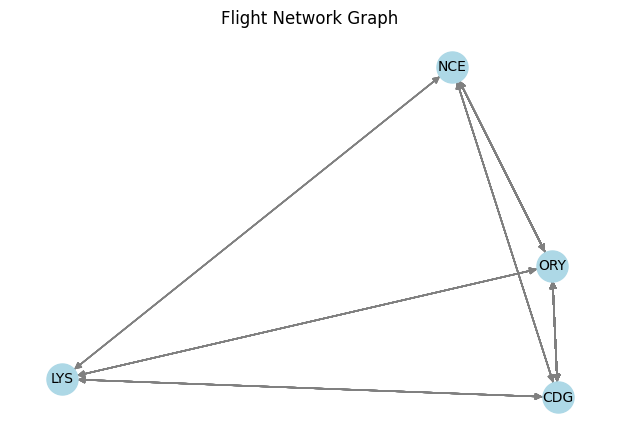

In [128]:
plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Flight Network Graph")
plt.show()

# Where should the aircrafts start and end the day?
At the start of the disruption day, each aircraft starts from a particular airport, and must end the day at a particular airport. This is to ensure that the aircraft fleet is ready and available for uninterrupted flight operations for the next day.

We now read the information on the aircraft fleet's starting position (called the source) and ending position (called the sink). 

In [129]:

flight_origin = df_current_plan.set_index('flight')['ori'].to_dict()
flight_dest = df_current_plan.set_index('flight')['des'].to_dict()
flight_start_time = df_current_plan.set_index('flight')['start_time'].to_dict()
flight_end_time = df_current_plan.set_index('flight')['end_time'].to_dict() 


In [130]:
df_starting_positions = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/starting_positions.csv')  
# if you run this notebook locally, you can also use
#df_starting_positions = pd.read_csv('data/starting_positions.csv')  
aircrafts_startpositions_airc = df_starting_positions.set_index('aircraft')['airport'].to_dict()

df_ending_positions = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/ending_positions.csv')
# if you run this notebook locally, you can also use
#df_ending_positions = pd.read_csv('data/ending_positions.csv')
aircrafts_endpositions_airc = df_ending_positions.set_index('aircraft')['airport'].to_dict()


In [131]:
df_starting_positions

,aircraft,airport
0,TranspCom#3,ORY
1,TranspCom#1,CDG
2,TranspCom#4,ORY
3,TranspCom#2,CDG
4,ERJ135#2,LEH
...,...,...
80,A319#12,ORY
81,A321#5,MPL
82,CRJ100#1,TLS
83,A319#9,ORY


In [132]:
df_ending_positions

,aircraft,airport
0,TranspCom#3,ORY
1,TranspCom#1,CDG
2,TranspCom#2,ORY
3,TranspCom#4,CDG
4,CRJ700#1,TLS
...,...,...
80,BAE300#2,LRT
81,ERJ135#1,ORY
82,BAE300#1,LIG
83,ERJ145#1,AVN


# Passenger Itineraries
Next, we read the passenger itinerary data. For each flight, we know how many passengers booked the tickets and the cost of each seat. We will store this information in dictionaries so that we can later assess the cost of cancelling a flight.

In [133]:
df_iterinaries = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/aviation_planning/data/flight_iterinaries.csv')
#df_iterinaries = pd.read_csv('data/flight_iterinaries.csv')
df_iterinaries['total_cost'] = df_iterinaries['cost'] * df_iterinaries['n_pass']
flight_revenue = df_iterinaries.groupby(['flight'])['total_cost'].agg('sum').to_dict() 
flight_n_pass = df_iterinaries.groupby(['flight'])['n_pass'].agg('sum').to_dict()

df_iterinaries


,cost,n_pass,flight,total_cost
0,137.5,24.0,4296.0,3300.0
1,137.5,33.0,4296.0,4537.5
2,137.5,24.0,4296.0,3300.0
3,137.5,44.0,4296.0,6050.0
4,137.5,35.0,4295.0,4812.5
...,...,...,...,...
1925,200.0,15.0,2620.0,3000.0
1926,250.0,6.0,2609.0,1500.0
1927,250.0,4.0,2609.0,1000.0
1928,325.0,16.0,5125.0,5200.0


# Create flight-to-flight transitions for each aircraft

Finally, using the current flight plan, we assess all the feasible flight-to-flight transitions. Such a transition is  essentially: after each flight, what is the next possible flight?

For two flights $f_1$ and $f_2$, the flight transition $f_1$-$f_2$ is *feasible* if the arrival time of $f_1$ is before the departure time of $f_2$, and the destination of $f_1$ is the same as the origin of $f_2$.

Based on these feasible transitions, each aircraft's route is a sequence of flight-to-flight transitions starting from the source airport to its sink airport.


For example, from the data, the aircraft A380#1 (which is an Airbus 380) starts the day at airport CFE. From here, it can either take flight 4296 (CFE-ORY) at 5:40am or flight 4298 (CFE-ORY) at 10:48am. Once it gets to ORY, it will have multiple options for the rest of the day's route. In total,  A380#1 has eight flight paths (see visualization below).

To compactly store all the feasible flight-to-flight transitions, we create a **directed acyclic graph** (DAG). The vertices are the flights, and the directed edges are feasible transitions. Use the interactive tool below to visualize the DAG for each aircraft.

In [134]:
# %pip install ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual

aircraft_flights = df_current_plan.groupby(['aircraft']).apply(lambda x: x['flight'].tolist()).to_dict()
flight_arcs_for_each_aircraft = {}
deltaplus_flightarcs = {}
deltaminus_flightarcs = {}
for a in aircraft_flights:
    print(aircraft_flights)
    print(a)
    aircraft_flights[a] += ['source_%s'%a,'sink_%s'%a]
    flight_origin['source_%s'%a] = aircrafts_startpositions_airc[a]
    flight_dest['source_%s'%a] = aircrafts_endpositions_airc[a]
    flight_origin['sink_%s'%a] = aircrafts_endpositions_airc[a]
    flight_dest['sink_%s'%a] = aircrafts_startpositions_airc[a]

    flight_start_time['source_%s'%a] = datetime.strptime('0:0', '%H:%M').time()
    flight_end_time['source_%s'%a] = datetime.strptime('0:0', '%H:%M').time()

    flight_start_time['sink_%s'%a] = datetime.strptime('23:59', '%H:%M').time()
    flight_end_time['sink_%s'%a] = datetime.strptime('23:59', '%H:%M').time()

    flight_arcs_for_each_aircraft[a] = []
    deltaplus_flightarcs[a] = {f: [] for f in aircraft_flights[a]}
    deltaminus_flightarcs[a] = {f: [] for f in aircraft_flights[a]}

    for f1 in aircraft_flights[a]:
        for f2 in aircraft_flights[a]:
            if f1 != f2 and flight_end_time[f1] < flight_start_time[f2] and flight_dest[f1] == flight_origin[f2]:
                flight_arcs_for_each_aircraft[a].append((f1, f2))
                deltaplus_flightarcs[a][f1].append(f2)
                deltaminus_flightarcs[a][f2].append(f1) 


{'A318#4': [3064, 3069, 3074, 3077, 3082, 3085, 3092, 3095], 'A318#5': [3065, 3070, 3075, 3080, 3083, 3090, 3093], 'A318#7': [4515, 4506], 'A318#8': [3103, 3068, 3073, 3088, 3081, 3102], 'A319#11': [3107, 3108, 3097, 3086], 'A319#13': [3067], 'A319#18': [4514, 4503, 4516, 4509, 4510, 4513], 'A319#5': [3111, 3112], 'A319#9': [3091, 3084, 3099], 'A320#11': [4269, 4270, 4271, 4276], 'A320#14': [4504, 4507, 4508, 4511], 'A320#22': [4576, 4577, 4578, 4575], 'A320#24': [4574, 4565, 4566, 4569, 3106], 'A321#2': [4264, 4265, 4268, 4273, 4272, 4279, 4274, 4275], 'A321#4': [4563, 4564, 4567, 4568, 4571, 4572], 'CRJ700#3': [3076, 3063], 'ERJ145#5': [4694, 4693, 4696, 4699, 4700, 4695], 'TranspCom#1': [1, 75, 5, 79, 9, 83, 13, 87, 17, 91, 21, 95, 25, 99, 29, 103, 33, 107, 37, 111, 41, 115, 45, 119, 49, 123, 53, 127, 57, 131, 61, 135, 65, 139, 69, 143], 'TranspCom#2': [2, 76, 6, 80, 10, 84, 14, 88, 18, 92, 22, 96, 26, 100, 30, 104, 34, 108, 38, 112, 42, 116, 46, 120, 50, 124, 54, 128, 58, 132, 62, 

In [135]:
## after installing Visual C/C++ https://pygraphviz.github.io/documentation/stable/install.html 
# !python -m pip install --use-pep517 --config-setting="--global-option=build_ext" --config-setting="--global-option=-IC:\Program Files\Graphviz\include" --config-setting="--global-option=-LC:\Program Files\Graphviz\lib" pygraphviz

In [136]:
def visualize_aircraft_network(x): 
    G = nx.DiGraph()
    G.add_edges_from(flight_arcs_for_each_aircraft[x])
    plt.figure(figsize=(20,14)) 
    A_graph = to_agraph(G) 
    A_graph.layout('dot')    
    display(A_graph)             
    plt.show()
 
interact(visualize_aircraft_network, x=aircraft_flights.keys())

interactive(children=(Dropdown(description='x', options=('A318#4', 'A318#5', 'A318#7', 'A318#8', 'A319#11', 'A…

<function __main__.visualize_aircraft_network(x)>

# Optimization Model



A weather disruption diminishes the overall capacity of the airports, measured by the number of flights that can take-off and land. Given this reduced airport capacity, which flights should be operated, and what route should the aircrafts take? Our goal is to create an optimal flight plan that minimizes the overall revenue loss incurred from the cancelled flights.

This decision problem is modeled using a mathematical optimization model, which finds the best solution according to an objective function such that the solution satisfies a set of constraints. Here, a solution is expressed as a vector of real values or integer values called decision variables. Constraints are a set of equations or inequalities written as a function of the decision variables.

In this airline business model, the objective is to minimize the overall loss from all the cancelled flights. The decision variables decide which flights to operate/cancel, as well as construct a route for each aircraft that starts from its starting airport and ends at the airport it needs to be at the end of the day. There are three types of constraints: 
- (i) construct the flight route 
- (ii) ensure that a flight is operated only if it is in the flight route, and 
- (iii) ensure that the number of take-offs and landings are within the diminished capacity of the airports.


# Assumptions

There are many modeling assumptions made in this notebook, as this model serves as a starting point. At the end of the notebook, we suggest potential extensions. The following are some key assumptions.

- All airports have the same level of disruption, which is across the entire day.
- Assume that we know ahead of time the level of disruption at all airports.
- Ignore crew scheduling and maintainance issues.
- No consideration of how other airlines may react to the disruption.


# Input Parameters

Let us now define the input parameters and notations used for creating the model. The subscript $a$ will be used to denote each aircraft, $f$ for each flight, and $i$ for each airport.


- $N$: set of all airports
- $A$: set of all aircrafts
- $F$: set of all flights
- $F_a$: set of flights operated by aircraft $a$ in the current plan
- $E_a$: set of feasible flight-to-flight transitions for aircraft $a$ 
- $r_f$: revenue ($\$$) from operating flight $f$
- $(o_f,d_f)$: origin, destination airports for flight $f$
- $(C^{arr}_i,C^{dep}_i)$: maximum number of arrivals and departures in airport $i$
- $\alpha$: level of disruption

The following code loads the Gurobi python package and initiates the optimization model. 
The value of $\alpha$ is set to $50\%$.

In [171]:
# %pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
model = gp.Model("airline_disruption")
 
N = G.nodes() 

# Decision Variables

We now define the decision variables.
In our model, we want to do two things: pick flights to be operated by each aircraft and construct a route for each aircraft. 
The following notation is used to model these decision variables.


$x_{a,f}$: $1$, if aircraft $a$ operates flight $f$; $0$, otherwise

$y_{a,f_1,f_2}$: $1$, if aircraft $a$ operates flight $f_2$ immediately after flight $f_1$; $0$, otherwise

We will now add the variables to the Gurobi model using the addVar function.

In [172]:
x, y = {}, {}
for a in aircrafts:
    for f in aircraft_flights[a]:
        x[a,f] = model.addVar(name="x_%s,%s"%(a,f), vtype=GRB.BINARY)

    for (f1,f2) in flight_arcs_for_each_aircraft[a]:
        y[a,f1,f2] = model.addVar(name="y_%s,%s,%s"%(a,f1,f2), vtype=GRB.BINARY)

model.update()

# Define Objective Function

**Minimize the revenue from cancelled flights**

(We can change this to minimize delay)

Our goal is to **minimize** the total **lost revenue** from the cancelled flights. 
We capture this objective as a function of the decision variables.
Note that a flight is cancelled if $x_{a,f}$ is set to $0$.
The revenue lost from the flight is given by $(1-x_{a,f}) * r_f$.
Hence, the overall lost revenue across all aircrafts and cancelled flights is given by,


\begin{aligned} 
\textrm{Minimize } \ \sum_{a \in aircrafts} \ \sum_{f \in F_a} \ (1-x_{a,f}) * r_f
\end{aligned}

We now add this objective function to the model using the setObjective function.

In [173]:
objective = gp.quicksum((1-x[a,f])*flight_revenue[f] for a in aircrafts for f in aircraft_flights[a] if f in flight_revenue) # operating cost
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraint 1

**Construct each aircraft's flight path**

An aircraft begins the day from its starting airport (source) and ends the day at its final airport (sink). Its route during the day is constructed using the **y** decision variables. 

We do this by considering three cases for each aircraft: its starting flight, an intermediary flight, and its ending flight.

When a flight leaves its starting airport, we ensure that it can leave exactly once.
The flights in the set $\delta^+(source_a)$ gives the set of all candidate "first-flights" for the aircraft.
We ensure that exactly one of these flights is taken using the following equality for each aircraft $a$.

\begin{aligned} 
\sum_{f' \in \delta^+(source_a)} y_{a,source_a,f'} &= 1
\end{aligned} 

Similarly, a flight arrives at its final airport, we ensure that it enters the airport exactly once.
The flights in the set $\delta^-(sink_a)$ gives the set of all candidate "last-flights" for the aircraft, and we ensure that exactly one of these flights is taken.

\begin{aligned} 
\sum_{f' \in \delta^-(sink_a)} y_{a,f',sink_a} &= 1
\end{aligned}

For every intermediary flight $f$ in $F_a$ (that is neither the starting nor the ending flight), we ensure that the number of preceding and succeeding flights are the same. This is necessary to ensure the continuity of the flight path.
The following constraints are for each aircraft $a$ and  intermediary flight $f$ in $F_a$.

\begin{aligned} 
\sum_{f' \in \delta^+(f)} y_{a,f,f'} &= \sum_{f' \in \delta^-(i)} y_{a,f',f} 
\end{aligned}

In optimization modeling, these types of constraints are called **flow-balance** constraints.
These are used to model many famous problems such as shortest path, maximum flow problem, and the traveling salesman problem. Read more [here](https://web.mit.edu/15.053/www/AMP-Chapter-08.pdf).
The following code adds these constraints to the model one at a time.

In [174]:
for a in aircrafts:
    model.addConstr(sum(y[a,'source_%s'%a,f2] for f2 in deltaplus_flightarcs[a]['source_%s'%a]) == 1)
    model.addConstr(sum(y[a,f1,'sink_%s'%a] for f1 in deltaminus_flightarcs[a]['sink_%s'%a]) == 1)
    for f in aircraft_flights[a]:
        if str(f)[0] != 's':
            model.addConstr(sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f]) == sum(y[a,f1,f] for f1 in deltaminus_flightarcs[a][f]))

# Constraint 2

**A flight is operated only if it is traversed by an aircraft**

Next, we make sure that a flight $f$ is operated by an aircraft $a$ only if $f$ is in the route taken by $a$.
The quantity $\sum_{f' \in \delta^+(f)} y_{a,f,f'}$ gives us the number of arcs that leave flight $f$; there can be either $0$ arcs or $1$ arc. 
If this quantity is $0$, then aircraft $f$ does not traverse flight $f$, and we set $x_{a,f}$ to be $0$.
This constraint can be mathematically expressed by the following inequality for each aircraft $a$ and flight $f$ in $F_a$

\begin{aligned}  
x_{a,f} &\leq \sum_{f'\ \textrm{in }\ \delta^+(f)} y_{a,f,f'}
\end{aligned}

Let us now add these constraints to the model.

In [175]:
for a in aircrafts:
    for f in aircraft_flights[a]:
        model.addConstr(x[a,f] <= sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f])) # flight f is chosen only if it is traversed
        

# Constraint 3

**Maximum limit on the number of arrivals and departures from the airports**

Finally, we add the airport capacity constraints. 
For each airport, we know the total number of arrivals and departures on a regular day. 
However, on the disruption day, only a fraction of flights can land and take-off, given by the parameters $\alpha$.
For example, if $\alpha = 0.5$, only half the flights can land or take-off.
This condition can be mathematically expressed using the following inequalities for every airport $i$,

\begin{aligned} 
\sum_{\textrm{aircraft a}} \ \sum_{\textrm{flight }f \textrm{ that arrives at $i$}} x_{a,f} &\leq C^{arr}_{i} * \alpha \quad  \forall \ \textrm{airport } i, \\
\sum_{\textrm{aircraft a}} \ \sum_{\textrm{flight }f \textrm{ that departs from $i$}} x_{a,f} &\leq C^{dep}_{i} *\alpha \quad  \forall \ \textrm{airport } i.
\end{aligned}

The left hand side of the inequalities counts the total number of flights that land or take-off at the airports, and the right hand side sets the maximum limits.
As extreme cases, setting $\alpha  = 0$ implies that there is a complete shut-down of the airports, and $\alpha = 1$ implies that there is no disruption.

We can add these constraints to the model, with a default values set to $0.5$. Later in the notebook, we see how the disruption parameter affects the optimal flight plan.

In [176]:
alpha = .5 

for i in N:
    total_departures = len([f for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i])
    total_arrivals = len([f for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i])

    model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i) <= alpha*total_departures)
    model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i) <= alpha*total_arrivals)


In [177]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 536 rows, 1920 columns and 5742 nonzeros
Model fingerprint: 0x0ad99a5d
Variable types: 0 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+03, 6e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 1878476.0000
Presolve removed 498 rows and 1559 columns
Presolve time: 0.01s
Presolved: 38 rows, 361 columns, 722 nonzeros
Found heuristic solution: objective 801512.00000
Variable types: 0 continuous, 361 integer (344 binary)

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 801512 1.87848e+06 

Optimal solution fou

# Optimal Solution

In [178]:
operated_flights = {a: [f for f in aircraft_flights[a] if x[a,f].X > .5 if str(f)[0] != 's'] for a in aircrafts}

total_loss = round(model.objVal/10**6,2)
reserved_flights = sum(len(operated_flights[a]) for a in aircrafts)
passengers = sum(sum(flight_n_pass[f] for f in aircraft_flights[a] if x[a,f].X > .5) for a in aircrafts)
used_aircrafts = sum([1 if len(operated_flights[a]) > 0 else 0 for a in aircrafts])

print(f"Net revenue total loss: ${total_loss} million")
print(f"Optimal number of flights served: {reserved_flights}")
print(f"Optimal number of passengers transported: {passengers}")
print(f"Optimal number of aircrafts utilized: {used_aircrafts}")


Net revenue total loss: $0.8 million
Optimal number of flights served: 50
Optimal number of passengers transported: 5641.0
Optimal number of aircrafts utilized: 10


In [179]:
operated_flights

{'TranspCom#1': [],
 'TranspCom#3': [],
 'TranspCom#2': [],
 'TranspCom#4': [],
 'A320#22': [4576, 4577, 4578, 4575],
 'ERJ145#5': [4693, 4696, 4700, 4695],
 'A321#2': [4264, 4265, 4268, 4273, 4272, 4279, 4274, 4275],
 'A318#8': [3103, 3068, 3073, 3088, 3081, 3102],
 'A318#4': [3064, 3069, 3074, 3077, 3082, 3085, 3092, 3095],
 'A321#4': [],
 'A319#18': [4514, 4503, 4516, 4509, 4510, 4513],
 'A320#24': [],
 'A319#11': [3107, 3108, 3097, 3086],
 'A318#5': [3070, 3075, 3080, 3083, 3090, 3093],
 'A319#13': [],
 'A318#7': [],
 'A320#11': [],
 'A320#14': [],
 'A319#5': [3111, 3112],
 'CRJ700#3': [3076, 3063],
 'A319#9': []}

In [180]:
import gurobipy as gp
from gurobipy import GRB
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
 
N = G.nodes() 
 
def solve_flight_planning(x):    
    alpha = x 
    
    model = gp.Model("airline_disruption")
    x, y = {}, {}
    for a in aircrafts:
        for f in aircraft_flights[a]:
            x[a,f] = model.addVar(name="x_%s,%s"%(a,f), vtype=GRB.BINARY)

        for (f1,f2) in flight_arcs_for_each_aircraft[a]:
            y[a,f1,f2] = model.addVar(name="y_%s,%s,%s"%(a,f1,f2), vtype=GRB.BINARY)

    model.update()

    objective = gp.quicksum((1-x[a,f])*flight_revenue[f] for a in aircrafts for f in aircraft_flights[a] if f in flight_revenue) # operating cost
    model.setObjective(objective, sense=GRB.MINIMIZE)

    for a in aircrafts:
        model.addConstr(sum(y[a,'source_%s'%a,f2] for f2 in deltaplus_flightarcs[a]['source_%s'%a]) == 1)
        model.addConstr(sum(y[a,f1,'sink_%s'%a] for f1 in deltaminus_flightarcs[a]['sink_%s'%a]) == 1)
        for f in aircraft_flights[a]: 
            if str(f)[0] != 's':
                model.addConstr(sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f]) == sum(y[a,f1,f] for f1 in deltaminus_flightarcs[a][f]))

    for a in aircrafts:
        for f in aircraft_flights[a]:
            model.addConstr(x[a,f] <= sum(y[a,f,f2] for f2 in deltaplus_flightarcs[a][f])) # flight f is chosen only if it is traversed


    for i in N:
        total_departures = len([f for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i])
        total_arrivals = len([f for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i]) 

        model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i) <= alpha*total_departures)
        model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i) <= alpha*total_arrivals)

    model.setParam('OutputFlag', 0)
    model.optimize()

    operated_flights = {a: [f for f in aircraft_flights[a] if x[a,f].X > .5 if str(f)[0] != 's'] for a in aircrafts}

    total_loss = round(model.objVal/10**6,2)
    reserved_flights = sum(len(operated_flights[a]) for a in aircrafts)
    passengers = sum(sum(flight_n_pass[f] for f in aircraft_flights[a] if x[a,f].X > .5) for a in aircrafts)
    used_aircrafts = sum([1 if len(operated_flights[a]) > 0 else 0 for a in aircrafts])

    print(f"Net revenue total loss: ${total_loss} million")
    print(f"Optimal number of flights served: {reserved_flights}")
    print(f"Optimal number of passengers transported: {passengers}")
    print(f"Optimal number of aircrafts utilized: {used_aircrafts}")

    # the following lines are for visualization and needs the package pygraphviz (can be commented in case of troubles)
    print("Full network of operated flights:")
    G = nx.MultiDiGraph()
     
    aircraft_color = {aircrafts[i]:"#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(aircrafts))}
    for a in aircrafts:
        for f in operated_flights[a]:
            G.add_edge(flight_origin[f], flight_dest[f], color=aircraft_color[a])
    A_graph = to_agraph(G) 
    A_graph.layout('dot')  
    display(A_graph)

print("Select a value for the level of disruption at the airports:\n")
print("Select 0 for complete shutdown of all airports; select 1 for business-as-usual.\n")

interact(solve_flight_planning, x=(0,1,0.05)) 
      

Select a value for the level of disruption at the airports:

Select 0 for complete shutdown of all airports; select 1 for business-as-usual.



interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.solve_flight_planning(x)>

## Comparing with unoptimized situation

Under the same constraints of the problem, the code blocks below project unoptimized result (revenue loss). To assume the unoptimized result while keeping the constraints defined for the problem, below works use the same model defined above, with three constrains slightly modified. <br>
The manual allocation of flights.. 
1. utilize 75-95% of the maximum capacity under disruption ((0.75-95) $\times \alpha \times$ total_departure/arrivals)
2. does not well understand the value of operating a particular flight, but they know it is good to operate as much as possible.
3. initiates to solve with plans of 50-95% of the availble flights (whether or not a flight will be operated). This initial allocation can be changed as employees manually solve the problem to fit in constraints. 

As this unoptimized outcome has randomn output, the work below simulates for a thousand times to compare with the optimized outcome above.   

In [181]:
revenue_loss_list = []
reserved_flights_list = []
passengers_list = []
used_aircrafts_list = []
for _ in range(1,1000):
    model.reset()    
    # part 1: assumes manual assignment of x can be upto 95% of optimal value
    new_constraint_departure = model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_origin[f] == i) <= random.uniform(0.75,0.95)*alpha*total_departures)
    new_constraint_arrival = model.addConstr(sum(x[a,f] for a in aircrafts for f in aircraft_flights[a] if flight_dest[f] == i) <= random.uniform(0.75,0.95)*alpha*total_arrivals)

    # part 2: assumes manual assignment do not well distinguish of value of resource utilization
    objective = gp.quicksum(random.uniform(0, 1) * v for v in model.getVars() if v.VarName.startswith('x'))
    model.setObjective(objective, sense=GRB.MAXIMIZE)

    # part 3: assigns random binary value in x variables in the beginning of the optimization. The number of assignment is random percentage * alpha. 
    total_x_num = len(x)
    vars_selection_ratio = int(random.uniform(0.5,0.95) * alpha * total_x_num)    
    x_var_name_list = [var.VarName for var in model.getVars() if var.VarName.startswith('x')]
    x_var_sample = random.sample(x_var_name_list, vars_selection_ratio)
    for v  in model.getVars():
        if v.VarName in x_var_sample:
            v.Start = 1
        else:
            v.Start = 0

    model.optimize()

    revenue_loss = 0
    for a in aircrafts:
        for f in aircraft_flights[a]: 
            if f in flight_revenue:
                revenue_loss += (1 - x[a, f].X) * flight_revenue[f]
    revenue_loss_list.append(revenue_loss)
    operated_flights = {a: [f for f in aircraft_flights[a] if x[a,f].X > .5 if str(f)[0] != 's'] for a in aircrafts}
    reserved_flights = sum(len(operated_flights[a]) for a in aircrafts)
    # passengers = sum(sum(flight_n_pass[f] for f in aircraft_flights[a] if x[a,f].X > .5) for a in aircrafts)
    used_aircrafts = sum([1 if len(operated_flights[a]) > 0 else 0 for a in aircrafts])

    reserved_flights_list.append(reserved_flights)
    passengers_list.append(passengers)
    used_aircrafts_list.append(used_aircrafts)

    model.remove(new_constraint_departure)
    model.remove(new_constraint_arrival)
    model.update()

Discarded solution information
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-1340P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 538 rows, 1920 columns and 5780 nonzeros
Model fingerprint: 0x425abc18
Variable types: 0 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint R0 by 1.000000000

Found heuristic solution: objective 9.0992881
Presolve removed 210 rows and 256 columns
Presolve time: 0.01s
Presolved: 328 rows, 1664 columns, 4699 nonzeros
Variable types: 0 continuous, 1664 integer (1664 binary)
Found heuristic solution: objective 27.1821929

Root relaxation: objective 8.820487e+01, 2

The below shows the output of simulated, and unoptimized revenue losses. As the solver has to meet the constraints of the problem, it converges in the center at around $1.1 million to $1.25 million. <br>
Thus, it is shown that the optimized model this study created performs better than manual allocations. 

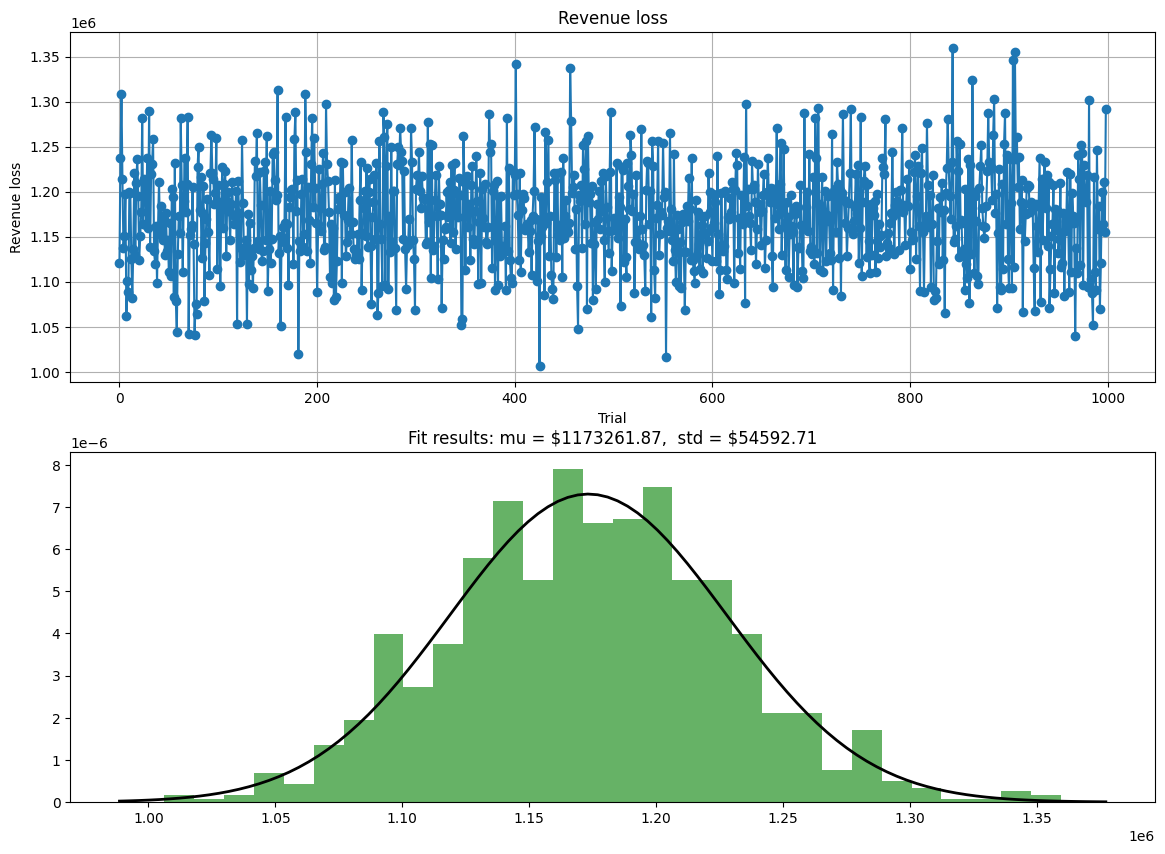

In [188]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
ax1.plot(revenue_loss_list, marker='o')
ax1.set_title('Revenue loss')
ax1.set_xlabel('Trial')
ax1.set_ylabel('Revenue loss')
ax1.grid(True)

data = np.array(revenue_loss_list)

# Fit a normal distribution to the data
mu, std = norm.fit(revenue_loss_list)

# Plot the histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = \$%.2f,  std = \$%.2f" % (mu, std)
plt.title(title)

plt.show()

In [189]:
# unoptimized output average
print(f"Net revenue total loss: ${round(np.average(revenue_loss_list) / 10**6, 2)} million")
print(f"Optimal number of flights served: {round(np.average(reserved_flights_list), 2)}")
print(f"Optimal number of passengers transported: {round(np.average(passengers_list), 2)}")
print(f"Optimal number of aircrafts utilized: {round(np.average(used_aircrafts_list), 2)}")

Net revenue total loss: $1.17 million
Optimal number of flights served: 113.46
Optimal number of passengers transported: 5641.0
Optimal number of aircrafts utilized: 13.76
